In [2]:
import casadi as ca
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interactive

In [ ]:
from cycler import cycler

default_cycler = (
    cycler(color=[
        '#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30',
        '#4DBEEE', '#A2142F', '#FF6F00', '#8DFF33', '#33FFF7',
    ]) +
    cycler('linestyle', [
        '-', '--', '-.', ':', '-',
        '--', '-.', ':', '-', '--'
    ])
)

textsize = 16
labelsize = 18

plt.rc('font', family='serif', serif='Times')
plt.rcParams["text.usetex"] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts} \DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}')
plt.rc('xtick', labelsize=textsize)
plt.rc('ytick', labelsize=textsize)
plt.rc('axes', titlesize=labelsize, labelsize=labelsize, prop_cycle=default_cycler)
plt.rc('legend', fontsize=textsize)
plt.rc('grid', linestyle='-.', alpha=0.5)
plt.rc('axes', grid=True)

plt.rcParams['figure.constrained_layout.use'] = True

In [ ]:
import numpy as np

# Example list of N arrays of dimension (3,1)
list_of_arrays = [np.array([[1, 2, 3]]), np.array([[4, 5, 6]]), np.array([[7, 8, 9]])]

# Convert the list of arrays into a matrix of dimension (N, 3)
matrix = np.vstack(list_of_arrays)

print(f"List of arrays: {list_of_arrays}")
print(f"matrix: {matrix.shape}")

In [ ]:
times = np.array([0.100, 0.297, 0.433, 0.642, 0.767, 1.0])
sum_of_groups = [np.sum(times[i:i+3]) for i in range(0, len(times), 3)]
print(sum_of_groups)

durations = np.diff(times)

durations = np.insert(durations, 0, times[0])

# print(durations)

pippo = [2]
print(pippo[0])

In [ ]:
from scipy.linalg import solve_continuous_are

A = np.array([[-1, 0], [1, 2]])
B = np.array([[1], [1]])

Q = 1000 * np.eye(2)
R = 1

P = solve_continuous_are(A, B, Q, R)

print(P)

### Generate Data

In [ ]:
from examples.example_non_autonomous_linear import test_non_autonomous_switched_linear_comparison

test_non_autonomous_switched_linear_comparison()

### Load Precomputed Data

In [ ]:
# Load data from a .mat file
data = scipy.io.loadmat('comparison_results.mat')

# Extract the relevant variables
optimal_costs = data['optimal_costs'][0] 
optimal_constraints = data['optimal_constraints'][0]
iter_array = data['iter_array'][0]  # Extract the array from the nested structure

constraints_value_ss = optimal_constraints[0].flatten()
constraints_value_ms = optimal_constraints[1].flatten()

### Plot Data

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6.4, 6.4))

# Plot the optimal costs function value
axs[0].plot(optimal_costs[0].flatten(), label='SS')
axs[0].plot(optimal_costs[1].flatten(), label='MS')
axs[0].set_xlim([1, len(optimal_costs[1])])
axs[0].set_xlabel('Number of Iterations')
axs[0].set_ylabel('Objective Function')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

# Plot the constraints violation
axs[1].plot(np.abs(constraints_value_ss), label='SS')
axs[1].plot(np.abs(constraints_value_ms), label='MS')
axs[1].set_xlim([1, len(optimal_costs[1])])
axs[1].set_xlabel('Number of Iterations')
axs[1].set_ylabel('Constraints Violation')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.savefig('obj_constr_vs_iter.pdf', format='pdf', bbox_inches='tight')

### Load Data

In [43]:
# Load data from a .mat file
data = scipy.io.loadmat('optimal_results_pannocchia_ms.mat')

# Extract the relevant variables
time_horizon = data['time_horizon'][0][0]
states = data['trajectory'][0]
controls = data['controls'][0]
phase_durations = data['phases_duration'][0]
n_states = data['n_states'][0][0]
n_phases = data['n_phases'][0][0]

A = np.array([[-0.1, 0, 0], [0, -2, -6.25], [0, 4, 0]])
B = np.array([[0.25], [2], [0]])
Q = 1. * np.eye(n_states)
R = 0.1 * np.eye(1)
from scipy.linalg import solve_continuous_are
P = np.array(solve_continuous_are(A, B, Q, R))

print(states[5])
print(type(phase_durations))

2.751551881514023
<class 'numpy.ndarray'>


### Compute accumulated cost function MS

In [28]:
state = ca.MX.sym('state', n_states)
control_input = ca.MX.sym('u', 1)
t = ca.MX.sym('t')

# state_evolution = aut_evol(t) @ state + forced_evol(t, control_input)
# state_evol = ca.Function('state_evol', [state, control_input, t], [state_evolution])
xdot = A @ state + B @ control_input

# x_ = ca.MX.sym('x_', n_states)
# u_ = ca.MX.sym('u_', 1)
# t_ = ca.MX.sym('t_')

# L = 0.5 * (ca.transpose(state_evol(x_, u_, t_)) @ Q @ state_evol(x_, u_, t_) + ca.transpose(u_) @ R @ u_)
L = 0.5 * (ca.transpose(state) @ Q @ state + ca.transpose(control_input) @ R @ control_input)
# l = ca.Function('l', [state, control_input], [L])

# Define the integrator for the cost function

dae = {'x': state, 'p': control_input, 'ode': xdot, 'quad': L}

# for d in range(1, steps):
#     Q_ += l(X0, U0, d*h)
# Q_ += l(X0, U0, Delta) / 2
# cost = Q_ * h
# cf = ca.Function('cf', [X0, U0, Delta], [cost])

# Compute the accumulated cost function
cost_ms = []
value_ms = 0
# cost_ms.append(value_ms)
for i in range(n_phases):
    x = states[n_states*i:n_states*(i+1)]
    u = controls[i]
    delta = phase_durations[i]
    dQ = ca.integrator('Q_', 'cvodes', dae, 0, delta)
    value_ms += dQ(x0=x, p=u)['qf']
    cost_ms.append(value_ms.full().flatten()[0])
i = n_phases
xf = states[n_states*i:n_states*(i+1)]
# Final cost
value_ms += 0.5 * ca.transpose(xf) @ P @ xf
cost_ms.append(value_ms.full().flatten()[0])

# Create the time grid
tgrid_ms = []
points = 1
time = 0
next_time = 0
for i in range(n_phases):
    next_time = next_time + phase_durations[i]
    tgrid_ms = np.concatenate((tgrid_ms, np.linspace(time, next_time, points, endpoint=False)))
    time = time + phase_durations[i]
tgrid_ms = np.concatenate((tgrid_ms, [time_horizon]))


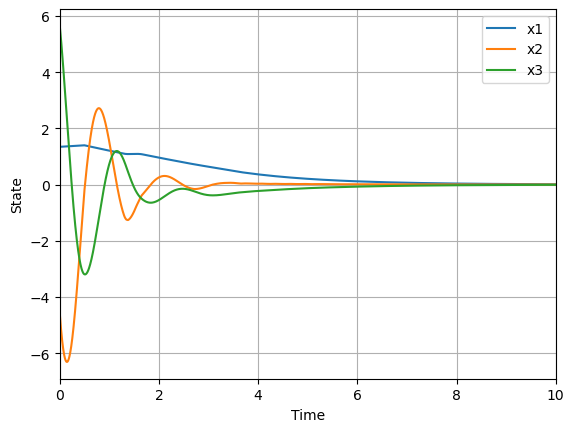

In [44]:
# Compute the state trajectory through a finer grid
A = np.array([[-0.1, 0, 0], [0, -2, -6.25], [0, 4, 0]])
B = np.array([[0.25], [2], [0]])

state = ca.MX.sym('state', n_states)
control_input = ca.MX.sym('u', 1)
t = ca.MX.sym('t')

xdot = A @ state + B @ control_input
dae = {'x': state, 'p': control_input, 'ode': xdot, 'quad': 0}

x0 = states[:n_states]
switching_instants = np.cumsum(phase_durations).tolist()
traj = [x0]
time = 0
M= 100
for switch in switching_instants:
    dt = (switch - time ) / M
    for i in range(M):
        dF = ca.integrator('dF', 'cvodes', dae, 0, dt)
        idx = switching_instants.index(switch)
        x0 = dF(x0=x0, p=controls[idx])['xf']
        traj.append(x0.full().flatten())
    time = switch
    
# Create the time grid mesh
time_grid = []
points = 100
time = 0
next_time = 0
for i in range(n_phases):
    next_time = next_time + phase_durations[i]
    time_grid = np.concatenate((time_grid, np.linspace(time, next_time, points, endpoint=False)))
    time = time + phase_durations[i]
time_grid = np.concatenate((time_grid, [time_horizon]))

# Plot the state trajectory
traj = np.array(traj)
plt.figure()
plt.plot(time_grid, traj[:, 0], label='x1')
plt.plot(time_grid, traj[:, 1], label='x2')
plt.plot(time_grid, traj[:, 2], label='x3')
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim([0, time_horizon])
plt.legend()
plt.grid()
plt.savefig('state_trajectory_ms.pdf', format='pdf', bbox_inches='tight')


### Load data SS

In [45]:
# Load data from a .mat file for SS
data_ss = scipy.io.loadmat('optimal_results_pannocchia_ss.mat')

time_horizon = data['time_horizon'][0][0]
states_ss = data_ss['trajectory']
controls_ss = data_ss['controls'][0]
phase_durations_ss = data_ss['phases_duration'][0]
n_states_ss = data_ss['n_states'][0][0]
n_phases_ss = data_ss['n_phases'][0][0]

### Compute accumulated cost function SS

In [21]:
# Compute the accumulated cost function
cost_ss = []
value_ss = 0
# cost_ss.append(value_ss)
for i in range(n_phases_ss):
    x = states_ss[i]
    u = controls_ss[i]
    delta = phase_durations_ss[i]
    dQ = ca.integrator('Q_', 'cvodes', dae, 0, delta)
    value_ss += dQ(x0=x, p=u)['qf']
    cost_ss.append(value_ss.full().flatten()[0])
i = n_phases_ss
xf = states_ss[i]
# Final cost
value_ss += 0.5 * np.transpose(xf) @ P @ xf
cost_ss.append(value_ss.full().flatten()[0])

# Create the time grid
tgrid_ss = []
points = 1
time = 0
next_time = 0
for i in range(n_phases_ss):
    next_time = next_time + phase_durations_ss[i]
    tgrid_ss = np.concatenate((tgrid_ss, np.linspace(time, next_time, points, endpoint=False)))
    time = time + phase_durations_ss[i]
tgrid_ss = np.concatenate((tgrid_ss, [time_horizon]))

### Plot cost functions evolution

12.72170971900821
12.72391060289621


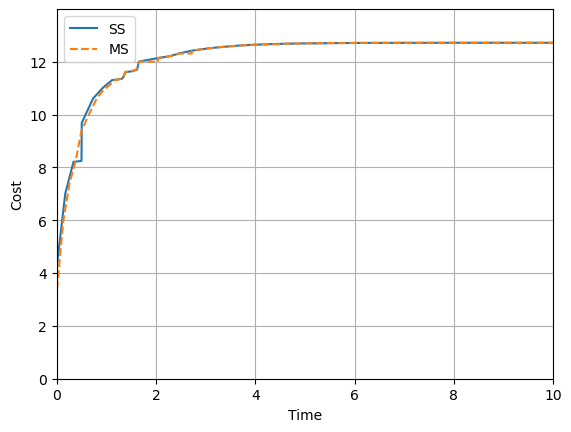

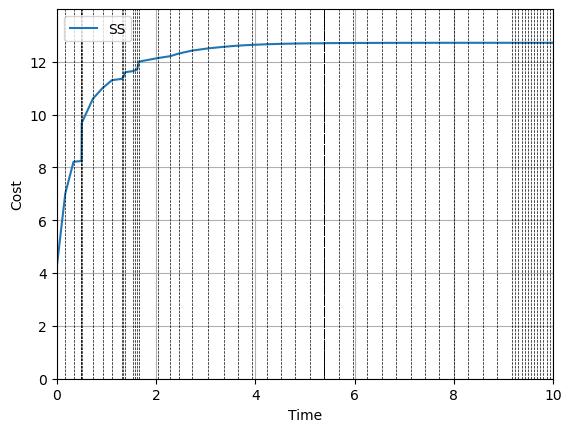

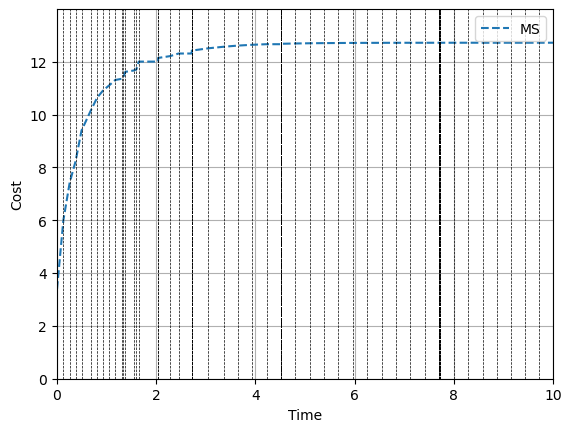

In [29]:
print(cost_ss[-1])
print(cost_ms[-1])


plt.figure()
plt.plot(tgrid_ss, cost_ss, label='SS')
plt.plot(tgrid_ms, cost_ms, label='MS', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.xlim([0, time_horizon])
plt.ylim([0, 1.1 * max(cost_ms)]) 

plt.legend()
plt.grid()

# plt.savefig('cost_ss_vs_cost_ms.pdf', format='pdf', bbox_inches='tight')


plt.figure()
plt.plot(tgrid_ss, cost_ss, label='SS')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.xlim([0, time_horizon])
plt.ylim([0, 1.1 * max(cost_ms)]) 

# Add vertical lines to identify phase changes instants
time = 0
for i in range(n_phases_ss):
    time = time + phase_durations_ss[i]
    plt.axvline(x=time, color='k', linestyle='--', linewidth=0.5)


plt.legend()
plt.grid()
# plt.savefig('cost_ss.pdf', format='pdf', bbox_inches='tight')


plt.figure()
plt.plot(tgrid_ms, cost_ms, label='MS', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.xlim([0, time_horizon])
plt.ylim([0, 1.1 * max(cost_ms)]) 

# Add vertical lines to identify phase changes instants
time = 0
for i in range(n_phases):
    time = time + phase_durations[i]
    plt.axvline(x=time, color='k', linestyle='--', linewidth=0.5)


plt.legend()
plt.grid()
# plt.savefig('cost_ms.pdf', format='pdf', bbox_inches='tight')


### Plot the system dynamics with a finer grid

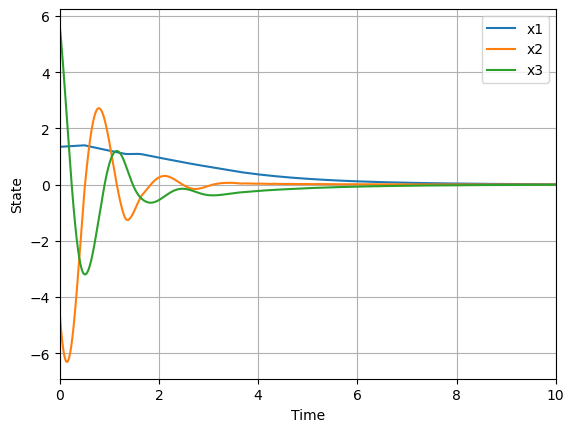

In [66]:
# Compute the state trajectory through a finer grid
A = np.array([[-0.1, 0, 0], [0, -2, -6.25], [0, 4, 0]])
B = np.array([[0.25], [2], [0]])

state = ca.MX.sym('state', n_states)
control_input = ca.MX.sym('u', 1)
t = ca.MX.sym('t')

xdot = A @ state + B @ control_input
dae = {'x': state, 'p': control_input, 'ode': xdot, 'quad': 0}

x0 = np.array(states_ss[0].flatten())
switching_instants_ss = np.cumsum(phase_durations_ss).tolist()
traj = [x0]
time = 0
M = 100
for switch in switching_instants_ss:
    dt = (switch - time ) / M
    for i in range(M):
        dF = ca.integrator('dF', 'cvodes', dae, 0, dt)
        idx = switching_instants_ss.index(switch)
        x0 = dF(x0=x0, p=controls_ss[idx])['xf']
        traj.append(x0.full().flatten())
    time = switch
    
# Create the time grid mesh
time_grid = []
points = M
time = 0
next_time = 0
for i in range(n_phases_ss):
    next_time = next_time + phase_durations_ss[i]
    time_grid = np.concatenate((time_grid, np.linspace(time, next_time, points, endpoint=False)))
    time = time + phase_durations_ss[i]
time_grid = np.concatenate((time_grid, [time_horizon]))

# Plot the state trajectory
traj = np.array(traj)
plt.figure()
plt.plot(time_grid, traj[:, 0], label='x1')
plt.plot(time_grid, traj[:, 1], label='x2')
plt.plot(time_grid, traj[:, 2], label='x3')
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim([0, time_horizon])
plt.legend()
plt.grid()
plt.savefig('state_trajectory_ss.pdf', format='pdf', bbox_inches='tight')


### New numerical example

In [68]:
A = np.array([[1, 0, 0], [-8, -5, 3], [2, -3, -5]])
B = np.array([[1], [0], [0]])

eigVal, eigVec = np.linalg.eig(A)
print(eigVal)

[-5.+3.j -5.-3.j  1.+0.j]
